Using TensorFlow backend.


(50000, 28, 28) (50000,)


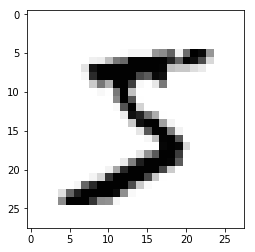

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [4]:
X_train = X_train.reshape(50000,28*28)
X_train.shape

(50000, 784)

In [5]:
X_val = X_val.reshape(10000, 28*28)

In [6]:
X_test = X_test.reshape(10000, 28*28)
X_test.shape

(10000, 784)

In [7]:
# One-hot encode target variables for softmax
y_train = convert_to_one_hot(y_train,10)
y_val = convert_to_one_hot(y_val,10)
y_test = convert_to_one_hot(y_test,10)

In [8]:
y_train.shape

(50000, 10)

In [9]:
X = tf.placeholder(tf.float32, shape=(None, 784))
Y = tf.placeholder(tf.float32, shape=(None, 10))

In [10]:
W1 = tf.get_variable("W1",  [784, 100], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1",  [100], initializer=tf.zeros_initializer())
W2 = tf.get_variable("W2",  [100, 100], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2",  [100], initializer=tf.zeros_initializer())
W3 = tf.get_variable("W3", [100, 10], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.get_variable("b3",  [10], initializer=tf.zeros_initializer())

In [11]:
Z1 = tf.add(tf.matmul(X, W1),b1)
A1 = tf.nn.relu(Z1)
Z2 = tf.add(tf.matmul(A1, W2),b2)
A2 = tf.nn.relu(Z2)
Z3 = tf.add(tf.matmul(A2, W3),b3)
A3 = tf.nn.softmax(Z3)

In [12]:
def compute_cost(A3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=A3))
    return cost

In [13]:
EPOCHS = 50
LEARNING_RATE = 0.0005

In [14]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=A3))
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
init = tf.global_variables_initializer()

In [15]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [16]:
batch_size = 500
with tf.Session() as sess:
    sess.run(init)
    train_costs = []
    val_costs = []
    for epoch in range(0,EPOCHS):
        #for i in range(0, 50000, batch_size):
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):            
            x_batch, y_batch = batch        
            #sess.run(optimizer, feed_dict={X:X_train[i:i+batch_size], Y:y_train[i: i+batch_size], keep_prob : 0.65})
            #sess.run(optimizer, feed_dict={X:X_train[i:i+batch_size], Y:y_train[i: i+batch_size]})
            sess.run(optimizer, feed_dict={X:x_batch, Y:y_batch})
        train_costs.append(sess.run(loss, feed_dict={X:X_train, Y:y_train}))
        val_costs.append(sess.run(loss, feed_dict={X:X_val, Y:y_val}))
        print("Epoch:", epoch, " train cost:", train_costs[-1]," val cost:", val_costs[-1])    
    
    # Predictions for test set
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    train_accuracy = accuracy.eval({X: X_train, Y: y_train})
    test_accuracy = accuracy.eval({X: X_test, Y: y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

Epoch: 0  train cost: 1.67093  val cost: 1.6623
Epoch: 1  train cost: 1.56624  val cost: 1.55644
Epoch: 2  train cost: 1.54792  val cost: 1.54131
Epoch: 3  train cost: 1.53641  val cost: 1.53204
Epoch: 4  train cost: 1.5283  val cost: 1.52552
Epoch: 5  train cost: 1.52275  val cost: 1.52065
Epoch: 6  train cost: 1.51753  val cost: 1.51637
Epoch: 7  train cost: 1.51258  val cost: 1.51196
Epoch: 8  train cost: 1.51033  val cost: 1.51084
Epoch: 9  train cost: 1.50642  val cost: 1.50775
Epoch: 10  train cost: 1.50386  val cost: 1.50541
Epoch: 11  train cost: 1.50191  val cost: 1.50451
Epoch: 12  train cost: 1.4994  val cost: 1.5033
Epoch: 13  train cost: 1.49742  val cost: 1.50156
Epoch: 14  train cost: 1.49554  val cost: 1.50114
Epoch: 15  train cost: 1.49425  val cost: 1.49996
Epoch: 16  train cost: 1.49245  val cost: 1.49874
Epoch: 17  train cost: 1.49124  val cost: 1.49901
Epoch: 18  train cost: 1.48958  val cost: 1.4977
Epoch: 19  train cost: 1.48862  val cost: 1.49715
Epoch: 20  trai

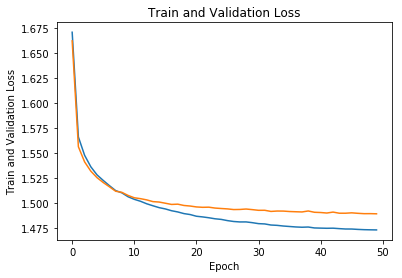

In [17]:
# Create a plot with the loss as requested
iterations = list(range(EPOCHS))
plt.plot(iterations, train_costs, label='Train')
plt.plot(iterations, val_costs, label='Val')
plt.ylabel('Train and Validation Loss')
plt.xlabel('Epoch')
plt.title("Train and Validation Loss")
plt.show()    